In [1]:
!python --version

Python 3.7.16


In [2]:
from Agent import Agent
#from NegotiationNet import NegotiationNet

import torch

import numpy as np

import os
os.chdir("..")
from rice import Rice

import matplotlib.pyplot as plt

In [2]:
envs = [Rice(region_yamls_filename='identical_region_yamls/') for _ in range(5)]
initial_state = envs[0].reset()

In [3]:
agents = [Agent(envs[0], initial_state[agent_id], agent_id) for agent_id in range(envs[0].num_agents)]

In [4]:
rs_difference = {agent.id : [] for agent in agents}
rs_negotiation = {agent.id : [] for agent in agents}

episode_length = envs[0].episode_length

for epoch in range(50):
    for batch in range(10):
        states = [env.reset() for env in envs]
        for t in range(envs[0].episode_length):
            collective_action = {}
            
            # Do negotiation
            for agent in agents:
                collective_action[agent.id] = agent.negotiate(
                    [state[agent.id] for state in states]
                )
                
            # Register proposals and promises
            for (i, env) in enumerate(envs):
                for agent in agents:
                    env.make_proposals(agent.id, np.array(collective_action[agent.id]['proposals'][i]))
            
            # Update masks
            for (i, env) in enumerate(envs):
                for agent in agents:
                    env.update_mask(agent.id, np.array(collective_action[agent.id]['decisions'][i]))
            
            # Act with default masks
            collective_action = {}
            for agent in agents:
                collective_action[agent.id] = agent.act(
                    [state[agent.id] for state in states],
                    with_mask = False
                )
            
            # Obtain rewards
            states, rewards_no_negotiation, _, _ = zip(*[
                env.step({agent_id : collective_action[agent_id][i] 
                        for agent_id in range(len(agents))}) 
                for (i, env) in enumerate(envs)
            ])
            
            # Rollback environments 1 step
            states = [env.rollback() for env in envs]
            
            # Act with negotiated masks
            collective_action = {}
            for agent in agents:
                collective_action[agent.id] = agent.act(
                    [state[agent.id] for state in states],
                )
            
            # Obtain rewards and new states
            states, rewards_negotiation, _, _ = zip(*[
                env.step({agent_id : collective_action[agent_id][i] 
                        for agent_id in range(len(agents))}) 
                for (i, env) in enumerate(envs)
            ])
            
            # rewards with negotiation - rewards without negotiation
            for (env_id, d) in enumerate(rewards_negotiation):
                for agent_id in d:
                    rewards_no_negotiation[env_id][agent_id] = \
                        -rewards_no_negotiation[env_id][agent_id] + \
                        rewards_negotiation[env_id][agent_id]
            
            # Register rewards into agents' buffers
            for agent in agents:
                r_difference = [reward[agent.id] for reward in rewards_no_negotiation]
                rs_difference[agent.id].append(r_difference)
                
                r_negotiation = [reward[agent.id] for reward in rewards_negotiation]
                rs_negotiation[agent.id].append(r_negotiation)
                
                agent.nets['negotiationNet'].buffer.rewards.extend(r_difference)
                agent.nets['negotiationNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
                
                agent.nets['activityNet'].buffer.rewards.extend(r_negotiation)
                agent.nets['activityNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
                
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
    for agent in agents:
        agent.update()

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40


In [5]:
rss_diff = {k: np.array(rs_difference[k]).mean(axis=1) for k in rs_difference}
rss_nego = {k: np.array(rs_negotiation[k]).mean(axis=1) for k in rs_negotiation}

In [4]:
# Cell without any negotiation

rs = {agent.id : [] for agent in agents}

episode_length = envs[0].episode_length

for epoch in range(50):
    for batch in range(10):
        states = [env.reset() for env in envs]
        for t in range(envs[0].episode_length):
            
            collective_action = {}
            for agent in agents:
                collective_action[agent.id] = agent.act(
                    [state[agent.id] for state in states],
                )
            
            # Obtain rewards and new states
            states, rewards, _, _ = zip(*[
                env.step({agent_id : collective_action[agent_id][i] 
                        for agent_id in range(len(agents))}) 
                for (i, env) in enumerate(envs)
            ])
            
            # Register rewards into agents' buffers
            for agent in agents:
                r = [reward[agent.id] for reward in rewards]
                rs[agent.id].append(r)
                
                agent.nets['activityNet'].buffer.rewards.extend(r)
                agent.nets['activityNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
                
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
    for agent in agents:
        agent.nets['activityNet'].update()

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40


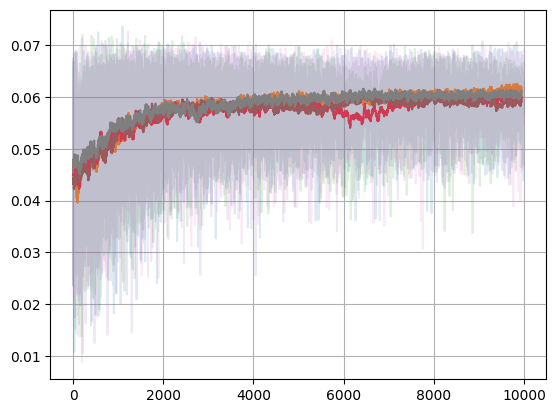

In [6]:
#rs = {k: np.array(rs[k]).mean(axis=1) for k in rs}
for r in rs:
    plt.plot(rs[r], alpha = .15)
    plt.plot(np.convolve(rs[r], np.ones(50)/50, mode = 'valid'))
plt.grid()
plt.show()

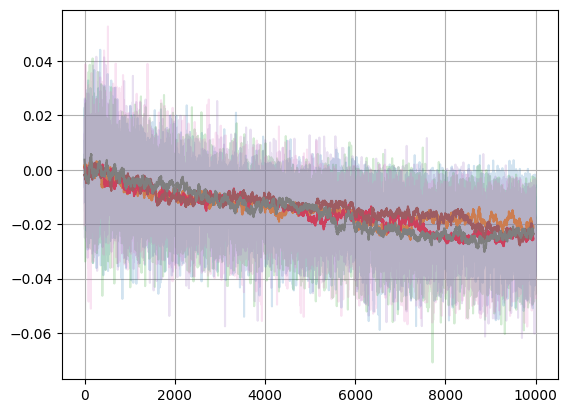

In [6]:
for r in rss_diff:
    plt.plot(rss_diff[r], alpha = .2)
    plt.plot(np.convolve(rss_diff[r], np.ones(50)/50, mode='valid'))

plt.grid()
plt.show()

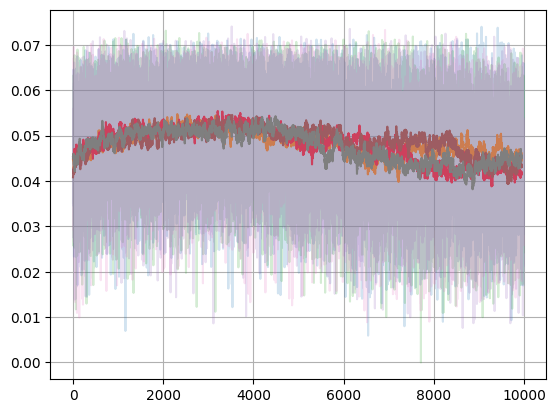

In [7]:
for r in rss_nego:
    plt.plot(rss_nego[r], alpha = .2)
    plt.plot(np.convolve(rss_nego[r], np.ones(50)/50, mode='valid'))

plt.grid()
plt.show()